# This notebook takes the Whatever we define as the "Base Layer" Data & Produces a list of Seed Points combined within a specific buffer (300ft currently) that have not passed the Evaluation Criteria

In [1]:
##Pandas and NumPy
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 8)
import numpy as np

##GeoSpatial imports
import geopandas as gpd
from geopy.distance import geodesic
import descartes as dc
import keplergl
from keplergl import KeplerGl

##for gemoetry to be compatible with geopandas
from shapely.wkt import load


## Swifter for applies
import swifter

## For distance calc test using columns
from math import sin, cos, sqrt, atan2, radians,pi
import gc
import datetime

##For map projections
import pyproj
from pyproj import Proj, transform, CRS

## manually setting proj directory bc I installed two. Data directory is finnicky. I just switch until it works :/
old = 'c:\\users\\rbijn006\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\pyproj\\proj_dir\\share\\proj'
new = 'c:\\users\\rbijn006\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\osgeo\\data\\proj'

pyproj.datadir.set_data_dir(new)


In [2]:
pyproj.datadir.get_data_dir()

'c:\\users\\rbijn006\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\osgeo\\data\\proj'

In [3]:
pyproj.datadir.set_data_dir(old)

In [4]:
## Filepaths to data, I ONLY NEED RT

r = "data/RT_OpenStores.csv"
#c=  "data/CXY_ALL_1_11_21.csv"

In [5]:
## Read in cxy for purpose of seeing if it will help distingusih dt from non-dt
#cxy = pd.read_csv(c)

## Possibly some unstructured info I could use to narrow down dt vs not dt, but nothing clear.
#cxy["OtherFields"].unique()
#cxy["AdditionalAttributes"].unique()


In [6]:
## Read in restaurant trends data
rt = pd.read_csv(r)

c:\users\rbijn006\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (38,42,75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
## Isolate the QSR segment of the rt data, which is 98% of the data
print(rt["SEGMENT"].unique())
print(len(rt[(rt["SEGMENT"]=="QSR")])/len(rt))

rt = rt[(rt["SEGMENT"]=="QSR")]

['QSR' 'FSR']
0.9855522395609398


In [8]:
## Next, exclude Popeyes 
rt = rt[~(rt["CHAIN"]=="Popeyes")]

In [9]:
## Then isolate drive-thru only locations
#pd.set_option("display.max_rows", None)
#rt.groupby("SERVICE_CODE").count()

### What I see here is many sites have a NA service code. I could go crazy trying to reconcile which sites are DT and which arent. Since I am just trying to get a solid base down, I will isolate bt DT for now, then come back to this later.

In [10]:
## Filtering for service code indicating that we have a drive_thru, resetting index as well



#rt_dt = rt[(rt["SERVICE_CODE"] =="DT")].reset_index(drop=True)


## Filtering only for military base b/c would be bad if MB kicked out a civillian point in the optimization
rt_dt = rt[~(rt["LOCATION_DESCRIPTION"]=='Military Base')]

In [11]:
## There are no NA values for County or State at this point
#rt[(rt["COUNTY"].isna())]
#rt[(rt["GEOSTATE"].isna())]

In [12]:
## Creating a location table
rt_dt_tbl = rt_dt[["STORE_NO","CHAIN", "LATITUDE","LONGITUDE"]]

In [13]:
rt_dt_tbl

,STORE_NO,CHAIN,LATITUDE,LONGITUDE
0,467925,1000 Degrees,40.687198,-74.312737
1,468071,800 Degrees Pizza,41.411226,-81.838519
2,468006,A & W,44.111902,-88.657309
3,467999,A & W,46.402699,-105.822015
...,...,...,...,...
158152,467836,Subway,42.017352,-71.020925
158153,467837,Mountain Mike's Pizza,38.469999,-122.729952
158154,467838,Captain D's,38.190631,-84.823982
158155,467839,Long John Silver's,38.845196,-76.884308


# Now doing a distance test between geodesic & columnwise calcs
## Results: columnwise is instant with error not exceeding 0.15 mi at 60 mi distance, geodesic ~13 seconds no error

In [12]:
test_pt = (44.111902,-88.657309)

rt_dt_tbl["dist_from_test_pt_geo"] = rt_dt_tbl.apply(lambda row: geodesic((row.LATITUDE,row.LONGITUDE),test_pt).feet, axis=1)

<ipython-input-12-51ec6c3464ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_dt_tbl["dist_from_test_pt_geo"] = rt_dt_tbl.apply(lambda row: geodesic((row.LATITUDE,row.LONGITUDE),test_pt).feet, axis=1)


In [13]:
#rt_dt_tbl

In [14]:
rt_dt_tbl["point_lat"] = 44.111902
rt_dt_tbl["point_lon"] = -88.657309

<ipython-input-14-66588f31a471>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_dt_tbl["point_lat"] = 44.111902
<ipython-input-14-66588f31a471>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_dt_tbl["point_lon"] = -88.657309


In [15]:
#rt_dt_tbl

In [16]:
## Runs instantly comapred to apply which takes ~13s. Output is in miles, using Earth's radius in miles (3959)
rt_dt_tbl['lat1']=(rt_dt_tbl['LATITUDE'])*pi/180
rt_dt_tbl['lat2']=(rt_dt_tbl['point_lat'])*pi/180
rt_dt_tbl['lon1']=(rt_dt_tbl['LONGITUDE'])*pi/180
rt_dt_tbl['lon2']=(rt_dt_tbl['point_lon'])*pi/180
rt_dt_tbl['x'] = (rt_dt_tbl['lon2'] - rt_dt_tbl['lon1']) * np.cos( 0.5*(rt_dt_tbl['lat2']+rt_dt_tbl['lat1']) )
rt_dt_tbl['y'] = rt_dt_tbl['lat2'] - rt_dt_tbl['lat1']
rt_dt_tbl['dist_cols']=21000000 * np.sqrt( rt_dt_tbl['x']*rt_dt_tbl['x'] + rt_dt_tbl['y']*rt_dt_tbl['y'] )
rt_dt_tbl.drop(columns=['lat1', 'lat2','lon1','lon2','x','y'],axis=1)

<ipython-input-16-026bd3f23b0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_dt_tbl['lat1']=(rt_dt_tbl['LATITUDE'])*pi/180
<ipython-input-16-026bd3f23b0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_dt_tbl['lat2']=(rt_dt_tbl['point_lat'])*pi/180
<ipython-input-16-026bd3f23b0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,STORE_NO,CHAIN,LATITUDE,LONGITUDE,dist_from_test_pt_geo,point_lat,point_lon,dist_cols
0,468006,A & W,44.111902,-88.657309,0.000000e+00,44.111902,-88.657309,0.000000e+00
1,467999,A & W,46.402699,-105.822015,4.489138e+06,44.111902,-88.657309,4.507414e+06
2,468134,Amigo's,41.232437,-96.119234,2.263405e+06,44.111902,-88.657309,2.270975e+06
3,468374,Arby's,40.738581,-80.316655,2.563912e+06,44.111902,-88.657309,2.573072e+06
...,...,...,...,...,...,...,...,...
63174,467749,Dunkin' Donuts,36.312855,-119.313629,8.960300e+06,44.111902,-88.657309,9.044155e+06
63175,467751,Dunkin' Donuts,36.840402,-76.094753,4.377209e+06,44.111902,-88.657309,4.401170e+06
63176,467752,Dunkin' Donuts,38.419521,-78.869827,3.393368e+06,44.111902,-88.657309,3.409346e+06
63177,467839,Long John Silver's,38.845196,-76.884308,3.748355e+06,44.111902,-88.657309,3.765299e+06


In [21]:
tst = rt_dt_tbl.iloc[1:,:]
tst["abs%_off"] = abs(tst['dist_from_test_pt_geo'] - tst['dist_cols'])/tst['dist_from_test_pt_geo']

<ipython-input-21-d5078ba82b50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst["abs%_off"] = abs(tst['dist_from_test_pt_geo'] - tst['dist_cols'])/tst['dist_from_test_pt_geo']


<AxesSubplot:ylabel='Frequency'>

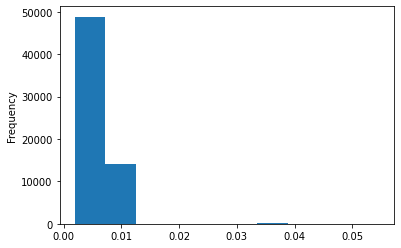

In [24]:
## Around 2,800 miles away from the test point we see errors of about 4.3%, or 118 miles off. Substantial, but we will never
## be analyzing stores that far away. Let's look at <60 miles away, as 50 is our furthest var
#tst[tst["abs%_off"]>0.04]

#tst[(tst["dist_from_test_pt_geo"]<60)&(tst["dist_from_test_pt_geo"]>50)]
tst["abs%_off"].plot.hist()
## Majority of errors below a tenth of a mile, do not exceed .15 miles at a 60mile max distance. acceptable to me.

In [25]:
## Now, write is as a function so multiple test points can be passed

##############
## Function is auto set to calculate in miles, column names being the same as first 4 are required
## Specify dist=21,000,000 for the calculation to come out in feet (Earth's radius in feet)
##############

def distcalc(df, dist=3959):
    df['lat1']=(df['LATITUDE'])*pi/180
    df['lat2']=(df['point_lat'])*pi/180
    df['lon1']=(df['LONGITUDE'])*pi/180
    df['lon2']=(df['point_lon'])*pi/180
    
    df['x'] = (df['lon2'] - df['lon1']) * np.cos( 0.5*(df['lat2']+df['lat1']) )
    df['y'] = df['lat2'] - df['lat1']
    df['dist_to_pt']=dist * np.sqrt( df['x']*df['x'] + df['y']*df['y'] )
    df = df.drop(columns=['lat1', 'lat2','lon1','lon2','x','y'],axis=1)
    return df

In [26]:
rt_dt_tbl.pipe(distcalc)

<ipython-input-25-30b53ab586a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat1']=(df['LATITUDE'])*pi/180
<ipython-input-25-30b53ab586a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat2']=(df['point_lat'])*pi/180
<ipython-input-25-30b53ab586a6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,STORE_NO,CHAIN,LATITUDE,LONGITUDE,dist_from_test_pt_geo,point_lat,point_lon,dist_cols,dist_to_pt
0,468006,A & W,44.111902,-88.657309,0.000000e+00,44.111902,-88.657309,0.000000e+00,0.000000
1,467999,A & W,46.402699,-105.822015,4.489138e+06,44.111902,-88.657309,4.507414e+06,849.754900
2,468134,Amigo's,41.232437,-96.119234,2.263405e+06,44.111902,-88.657309,2.270975e+06,428.132952
3,468374,Arby's,40.738581,-80.316655,2.563912e+06,44.111902,-88.657309,2.573072e+06,485.085337
...,...,...,...,...,...,...,...,...,...
63174,467749,Dunkin' Donuts,36.312855,-119.313629,8.960300e+06,44.111902,-88.657309,9.044155e+06,1705.038561
63175,467751,Dunkin' Donuts,36.840402,-76.094753,4.377209e+06,44.111902,-88.657309,4.401170e+06,829.725247
63176,467752,Dunkin' Donuts,38.419521,-78.869827,3.393368e+06,44.111902,-88.657309,3.409346e+06,642.742840
63177,467839,Long John Silver's,38.845196,-76.884308,3.748355e+06,44.111902,-88.657309,3.765299e+06,709.848585


# END DISTANCE TEST. 

# BEGIN TESTING HOW TO GET CONSISTENT 300FT RADII WITH MAPS

In [14]:
##Reducing to only necessary information, keeping store # so we can link back
rt_dt_tbl = rt_dt[["STORE_NO","CHAIN","GEOSTATE","COUNTY", "LATITUDE","LONGITUDE"]]

In [15]:
#Convert to GeoPandas: WORLD LAT LONG "EPSG:4326". 
rt_dt_tbl = gpd.GeoDataFrame(rt_dt_tbl,crs = "EPSG:4326" ,geometry=gpd.points_from_xy(rt_dt_tbl.LONGITUDE, rt_dt_tbl.LATITUDE))

In [16]:
## THIS IS FOR SETTING THE CRS OF THE TABLE, IT CHANGES NOTHING
#rt_dt_tbl = rt_dt_tbl.set_crs("EPSG:4326", allow_override=True)


In [17]:
## based on my crs I am working in degrees
## Checking my projection is correct
rt_dt_tbl.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Quick sanity check making sure all points are in the USA, maybe thats why the projections are bouncing

In [18]:
usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = usa[(usa["name"]=='United States of America')]

In [19]:
## writing column to check if in USA
rt_dt_tbl["inusa"] = rt_dt_tbl.apply(lambda row: usa.contains(row["geometry"]), axis=1)

In [20]:
rt_dt_tbl[~(rt_dt_tbl["inusa"])]

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry,inusa
37,468382,Arby's,WA,KITSAP,47.533585,-122.624488,POINT (-122.62449 47.53359),False
468,469761,Dunkin',MA,PLYMOUTH,41.913379,-70.553118,POINT (-70.55312 41.91338),False
811,468553,Jersey Mike's Submarines,WA,KITSAP,47.735416,-122.637550,POINT (-122.63755 47.73542),False
1516,50122,Arby's,WA,PIERCE,47.222175,-122.472249,POINT (-122.47225 47.22218),False
...,...,...,...,...,...,...,...,...
157837,467396,Burger King-NT,NY,KINGS,40.590256,-73.975044,POINT (-73.97504 40.59026),False
157859,467418,Taco Bell-TR,NY,QUEENS,40.605562,-73.755453,POINT (-73.75545 40.60556),False
157935,467498,Pizza Hut-TR,GA,GLYNN,31.159153,-81.391207,POINT (-81.39121 31.15915),False
158031,467601,Dunkin' Donuts,FL,PALM BEACH,26.608197,-80.057925,POINT (-80.05792 26.60820),False


In [21]:
## I KNEW IT!!! These 395 rows are not in the USA and are the reason that the USA map projections have been bouncing.
## Filter out these 395 rows and try again

rt_dt_tbl[~(rt_dt_tbl["inusa"])].groupby("GEOSTATE").count()

,STORE_NO,CHAIN,COUNTY,LATITUDE,LONGITUDE,geometry,inusa
GEOSTATE,,,,,,,
AK,11,11,11,11,11,11,11
AL,13,13,13,13,13,13,13
AZ,13,13,13,13,13,13,13
CA,87,87,87,87,87,87,87
...,...,...,...,...,...,...,...
SC,4,4,4,4,4,4,4
TX,84,84,84,84,84,84,84
VA,3,3,3,3,3,3,3
WA,259,259,259,259,259,259,259


### END SANITY CHECK, FILTER BELOW

In [22]:
rt_dt_tbl = rt_dt_tbl[(rt_dt_tbl["STORE_NO"].isin(rt_dt_tbl[(rt_dt_tbl["inusa"])]["STORE_NO"]))].drop("inusa", axis=1)

In [23]:
import copy
temp = copy.deepcopy(rt_dt_tbl)

In [24]:
temp

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry
0,467925,1000 Degrees,NJ,UNION,40.687198,-74.312737,POINT (-74.31274 40.68720)
1,468071,800 Degrees Pizza,OH,CUYAHOGA,41.411226,-81.838519,POINT (-81.83852 41.41123)
2,468006,A & W,WI,WINNEBAGO,44.111902,-88.657309,POINT (-88.65731 44.11190)
3,467999,A & W,MT,CUSTER,46.402699,-105.822015,POINT (-105.82201 46.40270)
...,...,...,...,...,...,...,...
158152,467836,Subway,MA,PLYMOUTH,42.017352,-71.020925,POINT (-71.02093 42.01735)
158153,467837,Mountain Mike's Pizza,CA,SONOMA,38.469999,-122.729952,POINT (-122.72995 38.47000)
158154,467838,Captain D's,KY,FRANKLIN,38.190631,-84.823982,POINT (-84.82398 38.19063)
158155,467839,Long John Silver's,MD,PRINCE GEORGE'S,38.845196,-76.884308,POINT (-76.88431 38.84520)


In [25]:
rt_dt_tbl = copy.deepcopy(temp)

In [26]:
rt_dt_tbl = gpd.GeoDataFrame(rt_dt_tbl,crs = "EPSG:4326" ,geometry=gpd.points_from_xy(rt_dt_tbl.LONGITUDE, rt_dt_tbl.LATITUDE))
rt_dt_tbl

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry
0,467925,1000 Degrees,NJ,UNION,40.687198,-74.312737,POINT (-74.31274 40.68720)
1,468071,800 Degrees Pizza,OH,CUYAHOGA,41.411226,-81.838519,POINT (-81.83852 41.41123)
2,468006,A & W,WI,WINNEBAGO,44.111902,-88.657309,POINT (-88.65731 44.11190)
3,467999,A & W,MT,CUSTER,46.402699,-105.822015,POINT (-105.82201 46.40270)
...,...,...,...,...,...,...,...
158152,467836,Subway,MA,PLYMOUTH,42.017352,-71.020925,POINT (-71.02093 42.01735)
158153,467837,Mountain Mike's Pizza,CA,SONOMA,38.469999,-122.729952,POINT (-122.72995 38.47000)
158154,467838,Captain D's,KY,FRANKLIN,38.190631,-84.823982,POINT (-84.82398 38.19063)
158155,467839,Long John Silver's,MD,PRINCE GEORGE'S,38.845196,-76.884308,POINT (-76.88431 38.84520)


In [27]:
##I am seperating AK & HI bc the lat/long distortion is the worst for those regions. Will combine after

## IS IN AK
rt_dt_tbl_AK = rt_dt_tbl[(rt_dt_tbl["GEOSTATE"].isin(["AK"]))]

## IS IN HI
rt_dt_tbl_HI = rt_dt_tbl[(rt_dt_tbl["GEOSTATE"].isin(["HI"]))]

## CONTINENTIAL US
rt_dt_tbl = rt_dt_tbl[~(rt_dt_tbl["GEOSTATE"].isin(["AK","HI"]))]

In [28]:
## should be 62744 when filtered by DT, 152073 when filtered by nothing, 151780 when no MBs.
print(f' Value should be 62774: Value is {len(rt_dt_tbl_AK)+len(rt_dt_tbl_HI)+len(rt_dt_tbl)}')

 Value should be 62774: Value is 151780


In [29]:
## When I select specific regions looking at max/min lat long
print(rt_dt_tbl["LATITUDE"].min(),rt_dt_tbl["LATITUDE"].max())
print(rt_dt_tbl["LONGITUDE"].min(),rt_dt_tbl["LONGITUDE"].max())

25.442578 48.994602
-124.38806799999999 -67.281587


## Below is for continential United States

In [30]:
## verify projection is in world lat/long
rt_dt_tbl.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

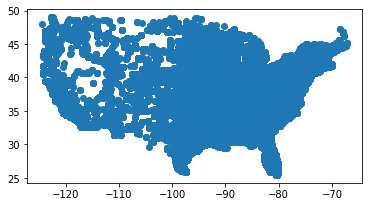

In [31]:
## Verifying we are only in the contenential USA
rt_dt_tbl.plot()

In [32]:
#rt_dt_tbl

In [33]:
## THIS IS WHERE WE SHALL CHANGE THE PROJECTION
## The projection I chose is ESRI:102003. A projection for the Continential USA
cr_to = CRS.from_user_input("ESRI:102003")
rt_dt_tbl = rt_dt_tbl.to_crs(cr_to)

In [34]:
##Verify our map projection was changed
rt_dt_tbl.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [35]:
## 300ft buffer ==> 600ft diameter, 300ft radius. ("a buffer of 300ft all the way around the point" ==> 600ft diameter)
## Converting 300ft to meters, which is 91.44 meters. If my map is a good projection, I should be able to input 91.44 for 
## the distance arguement and get back roughly 300ft radius circles



In [36]:
## Here are some comments that show why I needed to project to a new mapping plane: (old comments 3 #s)
### Tuned distance to 0.00105 based on below histogram & mean when working in 4236 projection
### Good news: the hist & mean seem to hold up when compared to multiple different boundary pts of the polygon (tested 0,1,2,3)
### Bad news: the errors are not unbiased and likely vary geographically (AK worst errors)

## Make sure CRS is consistent (ESRI:102003). Note input distance 91.44 meters

rt_dt_tbl["buff_pt"] = (rt_dt_tbl["geometry"].to_crs(crs = "ESRI:102003")).buffer(distance = 91.44)


In [37]:
## Verify crs was maintained among buffer points
rt_dt_tbl["buff_pt"].crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Begin seed pt

In [ ]:
## Create a geopandas dataframe from the unions
unions = gpd.GeoDataFrame(rt_dt_tbl["buff_pt"].unary_union, geometry=0)
## Set the CRS
unions = unions.set_crs(crs = "ESRI:102003")
unions.columns = ["geometry"]


## Create area columns & sort by area
unions["area"] = unions["geometry"].area
unions = unions.sort_values(by="area", ascending=False).reset_index(drop=True)

In [ ]:
unions

In [ ]:
unions["seed_LAT"] = unions["geometry"].centroid.to_crs("EPSG:4326").y
unions["seed_LON"] = unions["geometry"].centroid.to_crs("EPSG:4326").x
unions["STATE"] = "CONT_US"

In [ ]:
##Finally the cool part: Plotting all intersected buffers,their centroids (seed points), and the restaurants!!!
unions["geometry"] = unions["geometry"].to_crs("EPSG:4326")

temp_plt = gpd.GeoDataFrame(copy.deepcopy(unions))

#SEED POINTS!!!!!!
#map_5 = keplergl.KeplerGl(data={"cfa":temp_plt, "pts":rt_dt_tbl[["LATITUDE","LONGITUDE"]]})
#map_5

In [ ]:
unions

In [ ]:
unions.to_csv("results/raw_seedpoints/raw_seedpts_contusa_allrt.csv", index=False)

## Technically the seed points are done here. They are cen_x, cen_y

## Below is a verification of the circles radii

In [64]:
## Use Geodesic to verify the length of the circles radii is correct. Geodesic takes inputs in global lat/long format
## so, convert back to EPSG:4326

rt_dt_tbl["geometry"] = rt_dt_tbl["geometry"].to_crs(crs = "EPSG:4326")

rt_dt_tbl["buff_pt"] = rt_dt_tbl["buff_pt"].to_crs(crs = "EPSG:4326")

rt_dt_tbl = rt_dt_tbl.to_crs("EPSG:4326")

In [65]:
## Calculating distance b/t all points & their respective border of their spherse (radii)
rt_dt_tbl["buffer_dist"] = rt_dt_tbl.apply(lambda row: geodesic((row["buff_pt"].exterior.coords[0][1],row["buff_pt"].exterior.coords[0][0]),(row["geometry"].y,row["geometry"].x)).feet, axis=1)

301.7577501496547


<AxesSubplot:ylabel='Frequency'>

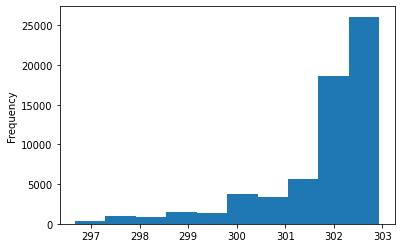

In [66]:
## Print the mean of the radii, and plot the histogram
print(np.mean(rt_dt_tbl["buffer_dist"]))
pd.Series(rt_dt_tbl["buffer_dist"]).plot.hist()

#Range bt 296-303. I can live with that.

In [67]:
##Now that we verified our spheres, drop buffer distance
rt_dt_tbl = rt_dt_tbl.drop("buffer_dist", axis=1)

In [68]:
rt_dt_tbl

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry,buff_pt
0,468006,A & W,WI,WINNEBAGO,44.111902,-88.657309,POINT (-88.65731 44.11190),"POLYGON ((-88.65617 44.11184, -88.65618 44.111..."
1,467999,A & W,MT,CUSTER,46.402699,-105.822015,POINT (-105.82201 46.40270),"POLYGON ((-105.82084 46.40278, -105.82083 46.4..."
2,468134,Amigo's,NE,DOUGLAS,41.232437,-96.119234,POINT (-96.11923 41.23244),"POLYGON ((-96.11813 41.23244, -96.11814 41.232..."
3,468374,Arby's,PA,BEAVER,40.738581,-80.316655,POINT (-80.31666 40.73858),"POLYGON ((-80.31558 40.73845, -80.31560 40.738..."
...,...,...,...,...,...,...,...,...
63174,467749,Dunkin' Donuts,CA,TULARE,36.312855,-119.313629,POINT (-119.31363 36.31286),"POLYGON ((-119.31263 36.31305, -119.31261 36.3..."
63175,467751,Dunkin' Donuts,VA,VIRGINIA BEACH (CITY,36.840402,-76.094753,POINT (-76.09475 36.84040),"POLYGON ((-76.09374 36.84023, -76.09377 36.840..."
63176,467752,Dunkin' Donuts,VA,HARRISONBURG (CITY),38.419521,-78.869827,POINT (-78.86983 38.41952),"POLYGON ((-78.86879 38.41937, -78.86881 38.419..."
63177,467839,Long John Silver's,MD,PRINCE GEORGE'S,38.845196,-76.884308,POINT (-76.88431 38.84520),"POLYGON ((-76.88327 38.84503, -76.88329 38.844..."


In [69]:
##Finally the cool part: Plotting all buffer regions and can see intersection as well as solo points!!!
temp_plt = gpd.GeoDataFrame(rt_dt_tbl[(rt_dt_tbl["LATITUDE"]!=0)],crs = "EPSG:4326", geometry = rt_dt_tbl[(rt_dt_tbl["LATITUDE"]!=0)]["buff_pt"] )
temp_plt = temp_plt.drop(["LATITUDE","LONGITUDE","buff_pt"], axis=1)

#Incredible buffer regions. A++
#map_5 = keplergl.KeplerGl(data={"cfa":temp_plt})
#map_5


## Now do the same for Alaska

In [70]:
rt_dt_tbl_AK

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry
284,468670,Firehouse Subs,AK,ANCHORAGE,61.127111,-149.885014,POINT (-149.88501 61.12711)
372,467978,McDonald's-TR,AK,ANCHORAGE,61.327042,-149.571295,POINT (-149.57129 61.32704)
396,468225,Raising Cane's,AK,ANCHORAGE,61.144907,-149.866514,POINT (-149.86651 61.14491)
16272,103104,Burger King-TR,AK,ANCHORAGE,61.195386,-149.910023,POINT (-149.91002 61.19539)
...,...,...,...,...,...,...,...
59123,444371,Taco Bell-TR,AK,MATANUSKA-SUSITNA,61.599191,-149.127901,POINT (-149.12790 61.59919)
61687,460768,Raising Cane's,AK,ANCHORAGE,61.230884,-149.740737,POINT (-149.74074 61.23088)
62056,462578,Wendy's,AK,MATANUSKA-SUSITNA,61.593838,-149.120743,POINT (-149.12074 61.59384)
62744,465999,Raising Cane's,AK,MATANUSKA-SUSITNA,61.578472,-149.415054,POINT (-149.41505 61.57847)


In [71]:
## When I select specific regions looking at max/min lat long
print(rt_dt_tbl_AK["LATITUDE"].min(),rt_dt_tbl_AK["LATITUDE"].max())
print(rt_dt_tbl_AK["LONGITUDE"].min(),rt_dt_tbl_AK["LONGITUDE"].max())

58.364351 64.859394
-151.523129 -134.576103


In [72]:
## verify projection is in world lat/long
rt_dt_tbl_AK.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

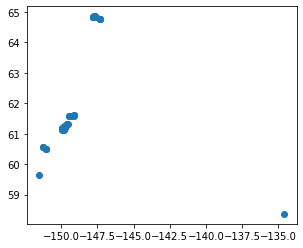

In [73]:
## Verifying we are only in the great north (Alaska)
rt_dt_tbl_AK.plot()

In [74]:
## THIS IS WHERE WE SHALL CHANGE THE PROJECTION
## The projection I chose for AK is Alaska Albers EPSG:3338

cr_to = CRS.from_user_input("EPSG:3338")
rt_dt_tbl_AK = rt_dt_tbl_AK.to_crs(cr_to)

In [75]:
##Verify our map projection was changed
rt_dt_tbl_AK.crs

<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meters)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [76]:
## Make sure CRS is consistent (EPSG:3338). Note input distance 91.44 meters

rt_dt_tbl_AK["buff_pt"] = (rt_dt_tbl_AK["geometry"].to_crs(crs = "EPSG:3338")).buffer(distance = 91.44)

In [77]:
## Verify crs was maintained among buffer points
rt_dt_tbl_AK["buff_pt"].crs

<Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meters)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Seed point dev begins here

In [78]:
## Create a geopandas dataframe from the unions
unions_AK = gpd.GeoDataFrame(rt_dt_tbl_AK["buff_pt"].unary_union, geometry=0)
## Set the CRS
unions_AK = unions_AK.set_crs(crs = "EPSG:3338")
unions_AK.columns = ["geometry"]


## Create area columns & sort by area
unions_AK["area"] = unions_AK["geometry"].area
unions_AK = unions_AK.sort_values(by="area", ascending=False).reset_index(drop=True)

In [79]:
unions_AK

,geometry,area
0,"POLYGON ((219688.251 1252672.891, 219687.663 1...",75491.712896
1,"POLYGON ((315838.053 1659651.957, 315837.904 1...",74196.359521
2,"POLYGON ((217295.657 1246094.051, 217295.217 1...",52442.216463
3,"POLYGON ((222468.529 1243186.830, 222468.089 1...",51412.231065
...,...,...
51,"POLYGON ((303366.660 1668051.788, 303366.220 1...",26225.540089
52,"POLYGON ((297869.363 1668708.753, 297868.923 1...",26225.540089
53,"POLYGON ((297781.258 1668966.883, 297780.817 1...",26225.540089
54,"POLYGON ((298464.751 1669545.371, 298464.311 1...",26225.540089


In [80]:
## At first was thinking of going through every single point & seeing if a union_buffers contained it
## Now thinking get the centroids of the union_buffers & dist calc b/t each point & centroids. Lowest dist centroid
## is assigned. Can maybe find a way to keep areas for stopping point?

## Now thinking do we even care to know what is in each point? That is for the eliminaton criteria to decide.

unions_AK["seed_LAT"] = unions_AK["geometry"].centroid.to_crs("EPSG:4326").y
unions_AK["seed_LON"] = unions_AK["geometry"].centroid.to_crs("EPSG:4326").x
unions_AK["STATE"] = "AK"

In [82]:
##Finally the cool part: Plotting all intersected buffers,their centroids (seed points), and the restaurants!!!
unions_AK["geometry"] = unions_AK["geometry"].to_crs("EPSG:4326")

temp_plt = gpd.GeoDataFrame(copy.deepcopy(unions_AK))

#SEED POINTS
#map_5 = keplergl.KeplerGl(data={"cfa":temp_plt, "pts":rt_dt_tbl_AK[["LATITUDE","LONGITUDE"]]})
#map_5

In [83]:
unions_AK

,geometry,area,seed_LAT,seed_LON,STATE
0,"POLYGON ((-149.89702 61.19446, -149.89703 61.1...",75491.712896,61.194998,-149.898348,AK
1,"POLYGON ((-147.35162 64.75586, -147.35163 64.7...",74196.359521,64.756624,-147.351577,AK
2,"POLYGON ((-149.94908 61.13706, -149.94909 61.1...",52442.216463,61.137901,-149.951158,AK
3,"POLYGON ((-149.85627 61.10826, -149.85628 61.1...",51412.231065,61.108676,-149.859289,AK
...,...,...,...,...,...
51,"POLYGON ((-147.59549 64.84179, -147.59552 64.8...",26225.540089,64.841864,-147.597411,AK
52,"POLYGON ((-147.70954 64.85235, -147.70957 64.8...",26225.540089,64.852431,-147.711459,AK
53,"POLYGON ((-147.71087 64.85473, -147.71090 64.8...",26225.540089,64.854810,-147.712794,AK
54,"POLYGON ((-147.69537 64.85932, -147.69540 64.8...",26225.540089,64.859394,-147.697289,AK


## End of seedpt for alaska. Below is just verifying ring size

In [84]:
## Use Geodesic to verify the length of the circles radii is correct. Geodesic takes inputs in global lat/long format
## so, convert back to EPSG:4326

rt_dt_tbl_AK["geometry"] = rt_dt_tbl_AK["geometry"].to_crs(crs = "EPSG:4326")

rt_dt_tbl_AK["buff_pt"] = rt_dt_tbl_AK["buff_pt"].to_crs(crs = "EPSG:4326")

rt_dt_tbl_AK = rt_dt_tbl_AK.to_crs("EPSG:4326")

In [85]:
## Calculating distance b/t all points & their respective border of their spherse (radii)
rt_dt_tbl_AK["buffer_dist"] = rt_dt_tbl_AK.apply(lambda row: geodesic((row["buff_pt"].exterior.coords[0][1],row["buff_pt"].exterior.coords[0][0]),(row["geometry"].y,row["geometry"].x)).feet, axis=1)

300.9156998836315


<AxesSubplot:ylabel='Frequency'>

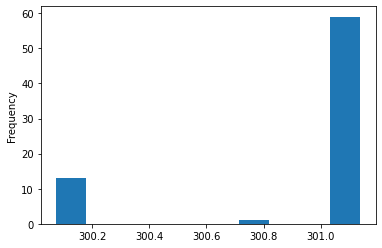

In [86]:
## Print the mean of the radii, and plot the histogram
print(np.mean(rt_dt_tbl_AK["buffer_dist"]))
pd.Series(rt_dt_tbl_AK["buffer_dist"]).plot.hist()

#Range real nice. 

In [87]:
##Now that we verified our spheres, drop buffer distance
rt_dt_tbl_AK = rt_dt_tbl_AK.drop("buffer_dist", axis=1)

In [1342]:
##Finally the cool part: Plotting all buffer regions and can see intersection as well as solo points!!!
temp_plt = gpd.GeoDataFrame(rt_dt_tbl_AK[(rt_dt_tbl_AK["LATITUDE"]!=0)],crs = "EPSG:4326", geometry = rt_dt_tbl_AK[(rt_dt_tbl_AK["LATITUDE"]!=0)]["buff_pt"] )
temp_plt = temp_plt.drop(["LATITUDE","LONGITUDE","buff_pt"], axis=1)

#Incredible buffer regions. A++
#map_5 = keplergl.KeplerGl(data={"cfa":temp_plt})
#map_5

In [1343]:
#rt_dt_tbl_AK

# Hawaii

In [88]:
rt_dt_tbl_HI

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry
394,469324,Raising Cane's,HI,HONOLULU,21.451942,-158.005924,POINT (-158.00592 21.45194)
395,469323,Raising Cane's,HI,HONOLULU,21.283695,-157.709959,POINT (-157.70996 21.28370)
16236,103006,Burger King-TR,HI,HONOLULU,21.423096,-157.748710,POINT (-157.74871 21.42310)
16237,103010,Burger King-TR,HI,HAWAII,19.643587,-155.994874,POINT (-155.99487 19.64359)
...,...,...,...,...,...,...,...
60501,453318,McDonald's-TR,HI,HONOLULU,21.336444,-157.914218,POINT (-157.91422 21.33644)
62058,462583,KFC-TR,HI,HAWAII,19.641683,-155.996548,POINT (-155.99655 19.64168)
62582,465569,Wendy's,HI,HONOLULU,21.381849,-158.145677,POINT (-158.14568 21.38185)
62583,465570,Taco Bell-TR,HI,HONOLULU,21.381849,-158.145677,POINT (-158.14568 21.38185)


In [89]:
## When I select specific regions looking at max/min lat long
print(rt_dt_tbl_HI["LATITUDE"].min(),rt_dt_tbl_HI["LATITUDE"].max())
print(rt_dt_tbl_HI["LONGITUDE"].min(),rt_dt_tbl_HI["LONGITUDE"].max())

19.504077 21.981039000000003
-159.386372 -154.954738


In [90]:
## verify projection is in world lat/long
rt_dt_tbl_HI.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

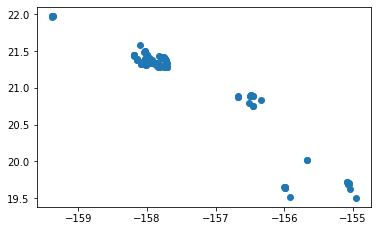

In [91]:
## Verifying we are only in beautiful Hawaii!
rt_dt_tbl_HI.plot()

In [92]:
## THIS IS WHERE WE SHALL CHANGE THE PROJECTION
## The projection I chose for HI is ESRI:102007, Hawaii_Albers_Equal_Area_Conic

cr_to = CRS.from_user_input("ESRI:102007")
rt_dt_tbl_HI = rt_dt_tbl_HI.to_crs(cr_to)

In [93]:
##Verify our map projection was changed
rt_dt_tbl_HI.crs

<Projected CRS: ESRI:102007>
Name: Hawaii_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Hawaii - main islands onshore.
- bounds: (-160.3, 18.87, -154.74, 22.29)
Coordinate Operation:
- name: Hawaii_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [94]:
## Make sure CRS is consistent (ESRI:102007). Note input distance 91.44 meters

rt_dt_tbl_HI["buff_pt"] = (rt_dt_tbl_HI["geometry"].to_crs(crs = "ESRI:102007")).buffer(distance = 92.1)

In [95]:
## Verify crs was maintained among buffer points
rt_dt_tbl_HI["buff_pt"].crs

<Projected CRS: ESRI:102007>
Name: Hawaii_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Hawaii - main islands onshore.
- bounds: (-160.3, 18.87, -154.74, 22.29)
Coordinate Operation:
- name: Hawaii_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## begin seed points

In [96]:
## Create a geopandas dataframe from the unions
unions_HI = gpd.GeoDataFrame(rt_dt_tbl_HI["buff_pt"].unary_union, geometry=0)
## Set the CRS
unions_HI = unions_HI.set_crs(crs = "ESRI:102007")
unions_HI.columns = ["geometry"]


## Create area columns & sort by area
unions_HI["area"] = unions_HI["geometry"].area
unions_HI = unions_HI.sort_values(by="area", ascending=False).reset_index(drop=True)

unions_HI

,geometry,area
0,"POLYGON ((-112609.252 923220.607, -112609.695 ...",81159.623537
1,"POLYGON ((105650.679 736349.656, 105650.235 73...",77007.121212
2,"POLYGON ((-107300.592 940368.232, -107301.036 ...",76498.269817
3,"POLYGON ((-101707.221 929976.413, -101708.207 ...",60054.998102
...,...,...
109,"POLYGON ((203418.599 742764.440, 203418.156 74...",26605.490282
110,"POLYGON ((203471.077 742264.456, 203470.634 74...",26605.490282
111,"POLYGON ((206367.111 734766.117, 206366.668 73...",26605.490282
112,"POLYGON ((-246599.649 994805.658, -246600.092 ...",26605.490282


In [97]:
unions_HI["seed_LAT"] = unions_HI["geometry"].centroid.to_crs("EPSG:4326").y
unions_HI["seed_LON"] = unions_HI["geometry"].centroid.to_crs("EPSG:4326").x
unions_HI["STATE"] = "HI"

In [99]:
##Finally the cool part: Plotting all intersected buffers,their centroids (seed points), and the restaurants!!!
unions_HI["geometry"] = unions_HI["geometry"].to_crs("EPSG:4326")

temp_plt = gpd.GeoDataFrame(copy.deepcopy(unions_HI))

##SEED POINTS!!!!!!
#map_5 = keplergl.KeplerGl(data={"cfa":temp_plt, "pts":rt_dt_tbl_HI[["LATITUDE","LONGITUDE"]]})
#map_5

In [100]:
unions_HI

,geometry,area,seed_LAT,seed_LON,STATE
0,"POLYGON ((-158.07798 21.33765, -158.07798 21.3...",81159.623537,21.338832,-158.078048,HI
1,"POLYGON ((-155.99567 19.64168, -155.99568 19.6...",77007.121212,19.642812,-155.995902,HI
2,"POLYGON ((-158.02782 21.49384, -158.02782 21.4...",76498.269817,21.494900,-158.029112,HI
3,"POLYGON ((-157.97386 21.39950, -157.97387 21.3...",60054.998102,21.399950,-157.973922,HI
...,...,...,...,...,...
109,"POLYGON ((-155.06584 19.69471, -155.06585 19.6...",26605.490282,19.694718,-155.066716,HI
110,"POLYGON ((-155.06538 19.69018, -155.06538 19.6...",26605.490282,19.690184,-155.066253,HI
111,"POLYGON ((-155.03839 19.62204, -155.03839 19.6...",26605.490282,19.622046,-155.039265,HI
112,"POLYGON ((-159.36691 21.98105, -159.36692 21.9...",26605.490282,21.981039,-159.367797,HI


## End seed pt below is verifying ring size

In [101]:
## Use Geodesic to verify the length of the circles radii is correct. Geodesic takes inputs in global lat/long format
## so, convert back to EPSG:4326

rt_dt_tbl_HI["geometry"] = rt_dt_tbl_HI["geometry"].to_crs(crs = "EPSG:4326")

rt_dt_tbl_HI["buff_pt"] = rt_dt_tbl_HI["buff_pt"].to_crs(crs = "EPSG:4326")

rt_dt_tbl_HI = rt_dt_tbl_HI.to_crs("EPSG:4326")

In [102]:
## Calculating distance b/t all points & their respective border of their spherse (radii)
rt_dt_tbl_HI["buffer_dist"] = rt_dt_tbl_HI.apply(lambda row: geodesic((row["buff_pt"].exterior.coords[0][1],row["buff_pt"].exterior.coords[0][0]),(row["geometry"].y,row["geometry"].x)).feet, axis=1)

300.2054638447435


<AxesSubplot:ylabel='Frequency'>

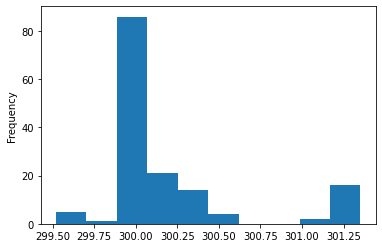

In [103]:
## Print the mean of the radii, and plot the histogram
print(np.mean(rt_dt_tbl_HI["buffer_dist"]))
pd.Series(rt_dt_tbl_HI["buffer_dist"]).plot.hist()

#Range real nice, a little wider than AK, but more rows spread across a further horizon 

In [104]:
##Now that we verified our spheres, drop buffer distance
rt_dt_tbl_HI = rt_dt_tbl_HI.drop("buffer_dist", axis=1)

In [105]:
##Finally the cool part: Plotting all buffer regions and can see intersection as well as solo points!!!
temp_plt = gpd.GeoDataFrame(rt_dt_tbl_HI[(rt_dt_tbl_HI["LATITUDE"]!=0)],crs = "EPSG:4326", geometry = rt_dt_tbl_HI[(rt_dt_tbl_HI["LATITUDE"]!=0)]["buff_pt"] )
temp_plt = temp_plt.drop(["LATITUDE","LONGITUDE","buff_pt"], axis=1)

#Incredible buffer regions. A++
#map_5 = keplergl.KeplerGl(data={"cfa":temp_plt})
#map_5

In [106]:
rt_dt_tbl_HI

,STORE_NO,CHAIN,GEOSTATE,COUNTY,LATITUDE,LONGITUDE,geometry,buff_pt
394,469324,Raising Cane's,HI,HONOLULU,21.451942,-158.005924,POINT (-158.00592 21.45194),"POLYGON ((-158.00504 21.45195, -158.00505 21.4..."
395,469323,Raising Cane's,HI,HONOLULU,21.283695,-157.709959,POINT (-157.70996 21.28369),"POLYGON ((-157.70908 21.28370, -157.70908 21.2..."
16236,103006,Burger King-TR,HI,HONOLULU,21.423096,-157.748710,POINT (-157.74871 21.42310),"POLYGON ((-157.74783 21.42310, -157.74783 21.4..."
16237,103010,Burger King-TR,HI,HAWAII,19.643587,-155.994874,POINT (-155.99487 19.64359),"POLYGON ((-155.99400 19.64358, -155.99400 19.6..."
...,...,...,...,...,...,...,...,...
60501,453318,McDonald's-TR,HI,HONOLULU,21.336444,-157.914218,POINT (-157.91422 21.33644),"POLYGON ((-157.91334 21.33645, -157.91334 21.3..."
62058,462583,KFC-TR,HI,HAWAII,19.641683,-155.996548,POINT (-155.99655 19.64168),"POLYGON ((-155.99567 19.64168, -155.99568 19.6..."
62582,465569,Wendy's,HI,HONOLULU,21.381849,-158.145677,POINT (-158.14568 21.38185),"POLYGON ((-158.14480 21.38185, -158.14480 21.3..."
62583,465570,Taco Bell-TR,HI,HONOLULU,21.381849,-158.145677,POINT (-158.14568 21.38185),"POLYGON ((-158.14480 21.38185, -158.14480 21.3..."


# Now we have initial seed points!

In [117]:
## Combining shaved 
print(f'Combining shaved off {len(rt_dt_tbl) - len(unions)} points, or {round(100*(len(rt_dt_tbl) - len(unions))/len(rt_dt_tbl),2)}% of all RT Drive-Thrus for Continental USA')
print(f'Combining shaved off {len(rt_dt_tbl_AK) - len(unions_AK)} points, or {round(100*(len(rt_dt_tbl_AK) - len(unions_AK))/len(rt_dt_tbl_AK),2)}% of all RT Drive-Thrus for Alaska')
print(f'Combining shaved off {len(rt_dt_tbl_HI) - len(unions_HI)} points, or {round(100*(len(rt_dt_tbl_HI) - len(unions_HI))/len(rt_dt_tbl_HI),2)}% of all RT Drive-Thrus for Hawaii')

Combining shaved off 18817 points, or 30.08% of all RT Drive-Thrus for Continental USA
Combining shaved off 18 points, or 24.66% of all RT Drive-Thrus for Alaska
Combining shaved off 36 points, or 24.16% of all RT Drive-Thrus for Hawaii


### So I do not forget. The geometry column is the various unions of the 300ft buffer rings, or the 300ft buffer ring by itself if there was no other buffer ring to union with. 

### The area is the area of the ring in meters squared (pi*pow(91.44m,2)). 

### Seed lat & long are the lat/long pairs of the centroids of the geometry (unions), which represent the seed points that have not yet passed the evaluation criterion (to come in the next notebook)

### STATE is a placeholder in the event that I need to come back here & determine the seed points residing state. I see no reason as of now why I would need this info, especially bc the computation to get it is incredibly expensive & it can be gotten later.

In [107]:
unions

,geometry,area,seed_LAT,seed_LON,STATE
0,"POLYGON ((-83.94855 38.07321, -83.94856 38.073...",199653.082246,38.075029,-83.949671,CONT_US
1,"POLYGON ((-111.96939 41.24347, -111.96938 41.2...",198739.095562,41.244639,-111.972855,CONT_US
2,"POLYGON ((-117.08147 34.84804, -117.08146 34.8...",181049.745578,34.850887,-117.082879,CONT_US
3,"POLYGON ((-84.53777 33.56779, -84.53779 33.567...",180358.265807,33.569272,-84.540125,CONT_US
...,...,...,...,...,...
43731,"POLYGON ((-100.76116 41.12055, -100.76116 41.1...",26225.540089,41.120509,-100.762259,CONT_US
43732,"POLYGON ((-91.03345 41.45171, -91.03346 41.451...",26225.540089,41.451754,-91.034547,CONT_US
43733,"POLYGON ((-90.52747 41.57133, -90.52748 41.571...",26225.540089,41.571374,-90.528574,CONT_US
43734,"POLYGON ((-92.86740 40.74396, -92.86741 40.743...",26225.540089,40.743982,-92.868494,CONT_US


In [108]:
unions_AK

,geometry,area,seed_LAT,seed_LON,STATE
0,"POLYGON ((-149.89702 61.19446, -149.89703 61.1...",75491.712896,61.194998,-149.898348,AK
1,"POLYGON ((-147.35162 64.75586, -147.35163 64.7...",74196.359521,64.756624,-147.351577,AK
2,"POLYGON ((-149.94908 61.13706, -149.94909 61.1...",52442.216463,61.137901,-149.951158,AK
3,"POLYGON ((-149.85627 61.10826, -149.85628 61.1...",51412.231065,61.108676,-149.859289,AK
...,...,...,...,...,...
51,"POLYGON ((-147.59549 64.84179, -147.59552 64.8...",26225.540089,64.841864,-147.597411,AK
52,"POLYGON ((-147.70954 64.85235, -147.70957 64.8...",26225.540089,64.852431,-147.711459,AK
53,"POLYGON ((-147.71087 64.85473, -147.71090 64.8...",26225.540089,64.854810,-147.712794,AK
54,"POLYGON ((-147.69537 64.85932, -147.69540 64.8...",26225.540089,64.859394,-147.697289,AK


In [109]:
unions_HI

,geometry,area,seed_LAT,seed_LON,STATE
0,"POLYGON ((-158.07798 21.33765, -158.07798 21.3...",81159.623537,21.338832,-158.078048,HI
1,"POLYGON ((-155.99567 19.64168, -155.99568 19.6...",77007.121212,19.642812,-155.995902,HI
2,"POLYGON ((-158.02782 21.49384, -158.02782 21.4...",76498.269817,21.494900,-158.029112,HI
3,"POLYGON ((-157.97386 21.39950, -157.97387 21.3...",60054.998102,21.399950,-157.973922,HI
...,...,...,...,...,...
109,"POLYGON ((-155.06584 19.69471, -155.06585 19.6...",26605.490282,19.694718,-155.066716,HI
110,"POLYGON ((-155.06538 19.69018, -155.06538 19.6...",26605.490282,19.690184,-155.066253,HI
111,"POLYGON ((-155.03839 19.62204, -155.03839 19.6...",26605.490282,19.622046,-155.039265,HI
112,"POLYGON ((-159.36691 21.98105, -159.36692 21.9...",26605.490282,21.981039,-159.367797,HI


In [118]:
## Write out data

###unions.to_csv("results/raw_seedpoints/raw_seedpts_contusa_v2.csv", index=False)
###unions_AK.to_csv("results/raw_seedpoints/raw_seedpts_ak.csv_v2", index=False)
###unions_HI.to_csv("results/raw_seedpoints/raw_seedpts_hi.csv_v2", index=False)